# VGG-19 Model

### Import required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19

### Define constants

In [2]:
TRAIN_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Training"
TEST_PATH = "/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/Testing"
IMAGE_SIZE = [224, 224]
BATCH_SIZE = 32
NUM_EPOCHS = 50

### Create data generators for training and validation with advanced data augmentation


In [3]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    TEST_PATH,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 4405 images belonging to 4 classes.
Found 1100 images belonging to 4 classes.
Found 1281 images belonging to 4 classes.


### Load the pre-trained VGG19 model without top layers

In [4]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

80134624/80134624 [==============================] - 0s 0us/step


### Add new fully connected layers on top of the base model

In [5]:
x = Flatten()(base_model.output)
prediction = Dense(train_generator.num_classes, activation='softmax')(x)

### Create the model

In [6]:
model = Model(inputs=base_model.input, outputs=prediction)

### Freeze the pre-trained layers in the base model and train only the new layers

In [7]:
for layer in base_model.layers:
    layer.trainable = False

Freeze all layers in the pre-trained model except the last two

In [8]:
#for layer in base_model.layers[:-2]:
 #   layer.trainable = False

### Model Summary

In [9]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Visualize the model architecture

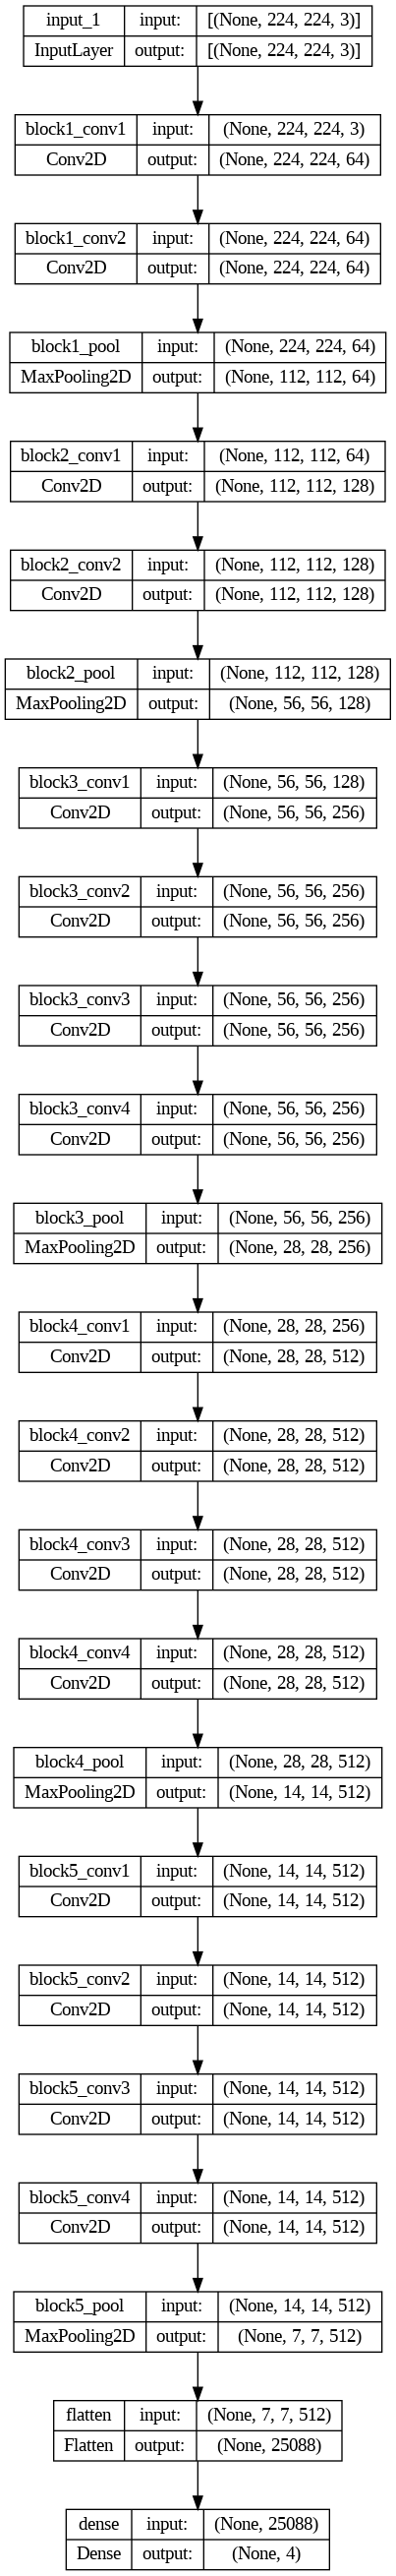

In [10]:
plot_model(model=model, show_shapes=True)

### Implement Early Stopping to prevent overfitting

In [11]:
#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min', restore_best_weights=True)

### Compile the model with categorical cross-entropy loss and a lower learning rate


In [12]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy'])

### Save the Model

In [13]:
checkpoint = ModelCheckpoint('/content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/VGG_19_Final.h5', 
                              monitor='val_accuracy', 
                              save_best_only=True, 
                              mode='max', 
                              verbose=1)

### Train the model on training data and evaluate on validation data

In [14]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[checkpoint])

Epoch 1/50
138/138 [==============================] - ETA: 0s - loss: 1.9323 - accuracy: 0.6558
Epoch 1: val_accuracy improved from -inf to 0.63091, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/VGG_19_Final.h5
138/138 [==============================] - 1162s 8s/step - loss: 1.9323 - accuracy: 0.6558 - val_loss: 2.5749 - val_accuracy: 0.6309
Epoch 2/50
138/138 [==============================] - ETA: 0s - loss: 1.0798 - accuracy: 0.7714
Epoch 2: val_accuracy improved from 0.63091 to 0.67636, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Classification RF/VGG_19_Final.h5
138/138 [==============================] - 108s 779ms/step - loss: 1.0798 - accuracy: 0.7714 - val_loss: 2.3669 - val_accuracy: 0.6764
Epoch 3/50
138/138 [==============================] - ETA: 0s - loss: 0.8292 - accuracy: 0.8154
Epoch 3: val_accuracy improved from 0.67636 to 0.70000, saving model to /content/drive/MyDrive/Deep_Learning/Brain Tumor MRI Clas

### Plot the training and validation accuracy

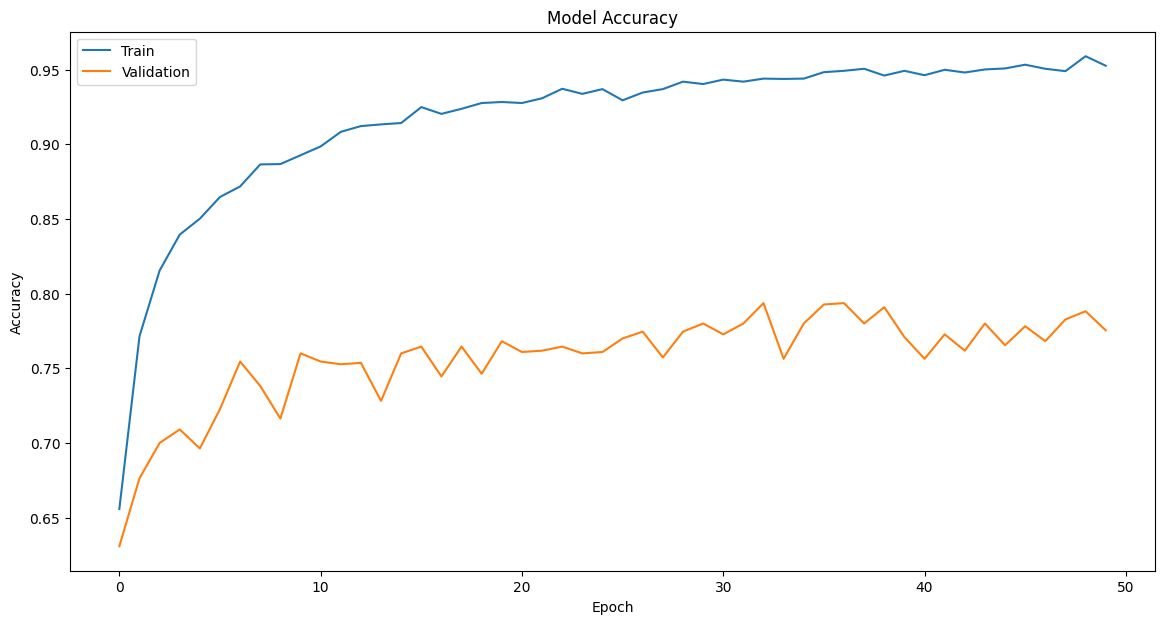

In [15]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['accuracy'])
ax.plot(history.history['val_accuracy'])
ax.set_title('Model Accuracy')
ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Plot the Training and Validation Loss

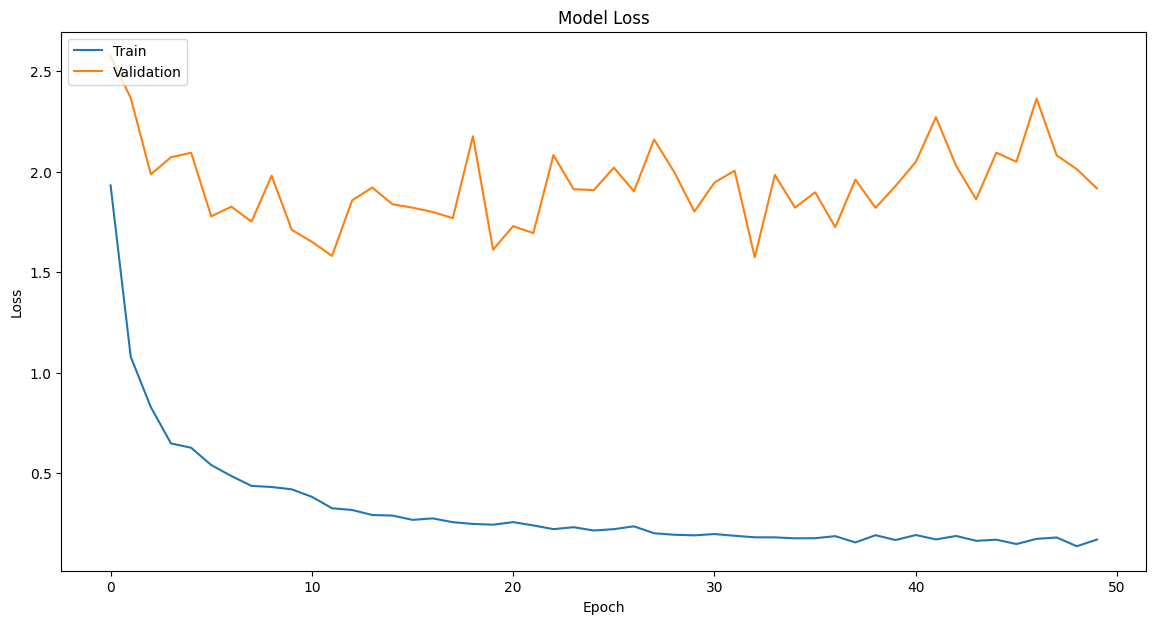

In [16]:
fig, ax = plt.subplots(figsize=(14,7))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Model Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### Test the model on the test data

In [17]:
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print("Test accuracy:", test_acc)

41/41 [==============================] - 312s 8s/step - loss: 1.0166 - accuracy: 0.8977
Test accuracy: 0.897736132144928


### Generate predictions on the test data

In [18]:
y_pred = model.predict(test_generator, steps=len(test_generator))
y_true = test_generator.classes

41/41 [==============================] - 12s 274ms/step


### Generate and plot confusion matrix

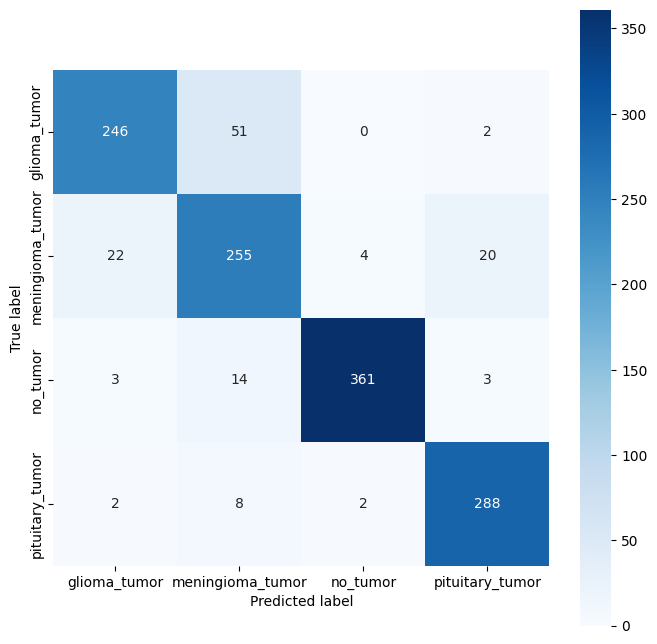

In [19]:
cm = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, cmap="Blues", square=True, xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys(), fmt='g')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

### Print classification report

In [20]:
class_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, np.argmax(y_pred, axis=1), target_names=class_names))

                  precision    recall  f1-score   support

    glioma_tumor       0.90      0.82      0.86       299
meningioma_tumor       0.78      0.85      0.81       301
        no_tumor       0.98      0.95      0.97       381
 pituitary_tumor       0.92      0.96      0.94       300

        accuracy                           0.90      1281
       macro avg       0.90      0.89      0.89      1281
    weighted avg       0.90      0.90      0.90      1281



### Compute precision, recall, F1 score and support for each class


In [21]:
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, np.argmax(y_pred, axis=1))

In [22]:
# Create a dataframe with the computed metrics for each class
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score,
    'Support': support
}, index=class_names)

#Print the dataframe
print(metrics_df)

                  Precision    Recall  F1 Score  Support
glioma_tumor       0.901099  0.822742  0.860140      299
meningioma_tumor   0.777439  0.847176  0.810811      301
no_tumor           0.983651  0.947507  0.965241      381
pituitary_tumor    0.920128  0.960000  0.939641      300


### Compute ROC and AUC for each class

In [23]:
fpr = {}
tpr = {}
roc_auc = {}

# Compute ROC and AUC for each class
for i in range(train_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

### Plot ROC curve for each class

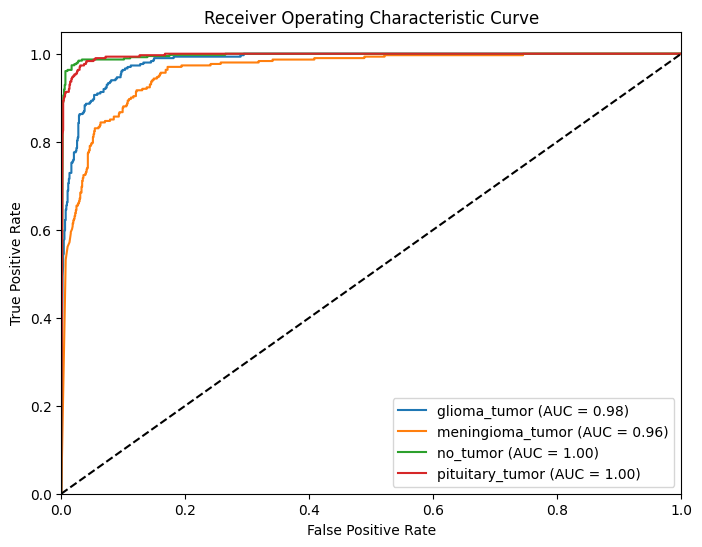

In [24]:
plt.figure(figsize=(8, 6))
for i in range(train_generator.num_classes):
    plt.plot(fpr[i], tpr[i], label='%s (AUC = %0.2f)' % (class_names[i], roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")
plt.show()